In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np
from os import listdir
from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval



Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Test
1,K01009.01,Train
2,K07621.01,Train
3,K06252.01,Train
4,K00958.01,Unlabeled


In [6]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.53594,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.24860,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.77449,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.97457,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.03900,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9


In [7]:
kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values

In [8]:
labels_train[:5]

array(['FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE',
       'FALSE POSITIVE', 'FALSE POSITIVE'], dtype=object)

In [9]:
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

# Matrices manuales

### Sólo en sentido izq-der

In [10]:
listdir('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos')

['MTF_u15_d30.npy',
 'MTF_u10_d30.npy',
 'MTF_u15_d20.npy',
 'MTF_u10_d20.npy',
 'MTF_u5_d20.npy',
 'MTF_u5_d15.npy',
 'MTF_u5_d10.npy',
 'MTF_u5_d30.npy',
 'MTF_u10_d10.npy',
 'MTF_u10_d15.npy',
 'MTF_u15_d15.npy',
 'MTF_u15_d10.npy']

In [11]:
def class2int(labels):
    y=[]
    for lab in labels:
        if lab=='FALSE POSITIVE':
            y.append(0)
        else:
            y.append(1)
    return y

In [12]:
#load data
matrices=np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d30.npy')

x_train=matrices[mask_train]
y_train=class2int(labels_train)

x_val=matrices[mask_test]
y_val=class2int(labels_val)

x_test=matrices[mask_unlabeled]
#y_test=#predecir



In [13]:
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Objetos de entrenamiento: (4692, 40, 40, 1)
Objetos de validación: (1565, 40, 40, 1)
Objetos de testing: (1797, 40, 40, 1)


In [14]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.80452675 1.32094595]


In [16]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 40, 40, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 128)       204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 39, 39, 256)       819456    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
__________

In [17]:
model1 = Sequential()
model1.add(Conv2D(64, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.1))
model1.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model1.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

model1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 40, 40, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 256)       295168    
_________________________________________________________________
global_average_pooling2d_4 ( (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
__________

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 68s 14ms/step - loss: 0.5903 - acc: 0.6360 - val_loss: 0.5926 - val_acc: 0.5546
Epoch 2/50
4692/4692 [==============================] - 67s 14ms/step - loss: 0.5580 - acc: 0.6405 - val_loss: 0.6061 - val_acc: 0.5284
Epoch 3/50
4692/4692 [==============================] - 66s 14ms/step - loss: 0.5548 - acc: 0.6413 - val_loss: 0.5941 - val_acc: 0.5559
Epoch 4/50
4692/4692 [==============================] - 66s 14ms/step - loss: 0.5523 - acc: 0.6473 - val_loss: 0.5980 - val_acc: 0.5502
Epoch 5/50
4692/4692 [==============================] - 67s 14ms/step - loss: 0.5543 - acc: 0.6507 - val_loss: 0.6139 - val_acc: 0.5399
Epoch 6/50
4692/4692 [==============================] - 67s 14ms/step - loss: 0.5581 - acc: 0.6413 - val_loss: 0.6141 - val_acc: 0.5240
Epoch 7/50
4692/4692 [==============================] - 67s 14ms/step - loss: 0.5503 - acc: 0.6385 - val_loss: 0.5934 - val_acc: 0.5649


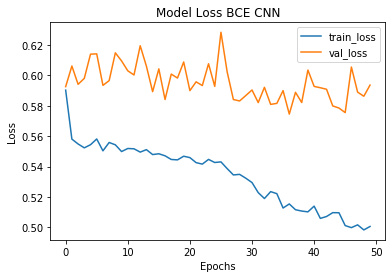

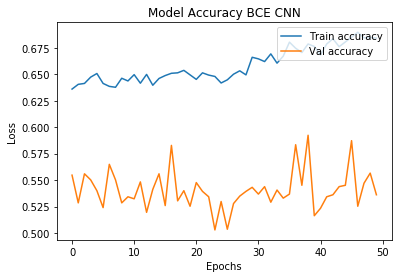

In [18]:
hist=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.928205,0.341509,0.499310,0.521429,0.533584,0.536102
Confirmed,0.405957,0.944554,0.567857,0.521429,0.533584,0.536102


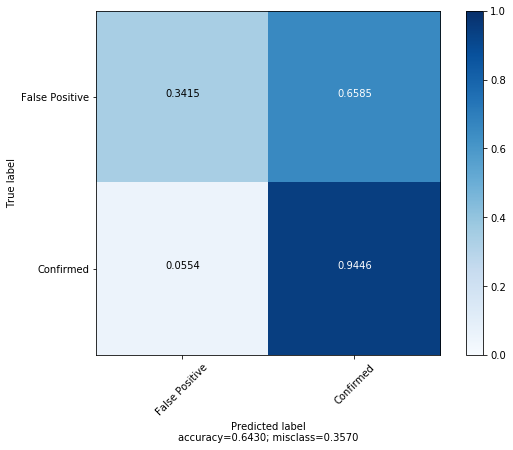

{'Precision raw': array([0.92820513, 0.40595745]), 'Recall raw': array([0.34150943, 0.94455446]), 'F1 raw': array([0.49931034, 0.56785714]), 'F1 weighted': 0.521429279655015, 'F1 macro': 0.5335837438423645, 'F1 micro': 0.5361022364217253, 'Confusion Matrix': array([[362, 698],
       [ 28, 477]])}


In [19]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 8s 2ms/step - loss: 0.6161 - acc: 0.6204 - val_loss: 0.6117 - val_acc: 0.5412
Epoch 2/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.5592 - acc: 0.6447 - val_loss: 0.6041 - val_acc: 0.6773
Epoch 3/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.5571 - acc: 0.6396 - val_loss: 0.6086 - val_acc: 0.5463
Epoch 4/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.5546 - acc: 0.6443 - val_loss: 0.6087 - val_acc: 0.5482
Epoch 5/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.5533 - acc: 0.6458 - val_loss: 0.6025 - val_acc: 0.5470
Epoch 6/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.5525 - acc: 0.6503 - val_loss: 0.5907 - val_acc: 0.5655
Epoch 7/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.5519 - acc: 0.6447 - val_loss: 0.6094 - val_acc: 0.5240
Epoch 8/50
469

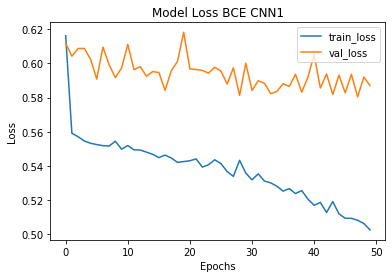

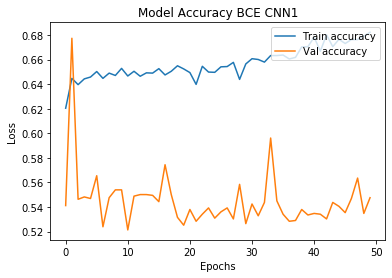

In [20]:
hist1=model1.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist1.history['loss'],label="train_loss")
plt.plot(hist1.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist1.history['acc'],label="Train accuracy" )
plt.plot(hist1.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.866667,0.392453,0.540260,0.544925,0.547488,0.547604
Confirmed,0.406452,0.873267,0.554717,0.544925,0.547488,0.547604


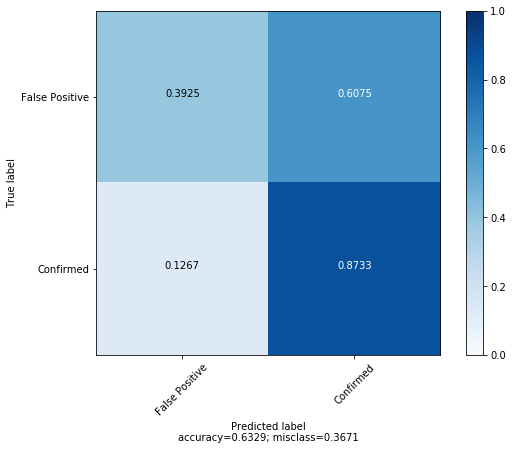

{'Precision raw': array([0.86666667, 0.40645161]), 'Recall raw': array([0.39245283, 0.87326733]), 'F1 raw': array([0.54025974, 0.55471698]), 'F1 weighted': 0.5449248563239764, 'F1 macro': 0.547488360695908, 'F1 micro': 0.5476038338658147, 'Confusion Matrix': array([[416, 644],
       [ 64, 441]])}


In [21]:
predichos=model1.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 + Reverse LC'))

In [22]:
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [23]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model2.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 40, 40, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 256)       295168    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
__________

In [24]:
y_train_cat=to_categorical(y_train, 2)
y_train_cat[:3]
y_val_cat=to_categorical(y_val, 2)
y_val_cat[:3]

array([[0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 8s 2ms/step - loss: 0.1578 - acc: 0.5735 - val_loss: 0.1562 - val_acc: 0.5265
Epoch 2/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.1477 - acc: 0.6189 - val_loss: 0.1544 - val_acc: 0.5252
Epoch 3/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.1439 - acc: 0.6345 - val_loss: 0.1594 - val_acc: 0.5131
Epoch 4/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.1447 - acc: 0.6277 - val_loss: 0.1544 - val_acc: 0.5252
Epoch 5/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.1448 - acc: 0.6338 - val_loss: 0.1582 - val_acc: 0.5125
Epoch 6/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.1434 - acc: 0.6311 - val_loss: 0.1549 - val_acc: 0.5220
Epoch 7/50
4692/4692 [==============================] - 7s 1ms/step - loss: 0.1429 - acc: 0.6321 - val_loss: 0.1547 - val_acc: 0.5291
Epoch 8/50
469

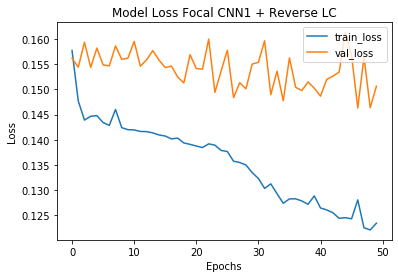

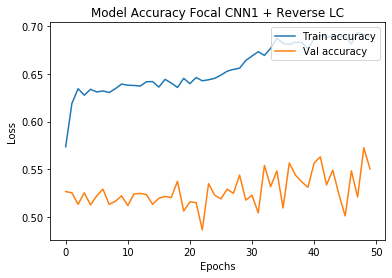

In [25]:
hist2=model2.fit(x_train, y_train_cat, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist2.history['loss'],label="train_loss")
plt.plot(hist2.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist2.history['acc'],label="Train accuracy" )
plt.plot(hist2.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.956410,0.351887,0.514483,0.535931,0.547718,0.55016
Confirmed,0.415319,0.966337,0.580952,0.535931,0.547718,0.55016


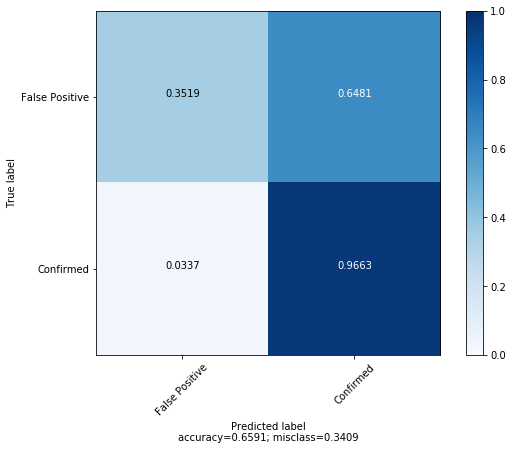

{'Precision raw': array([0.95641026, 0.41531915]), 'Recall raw': array([0.35188679, 0.96633663]), 'F1 raw': array([0.51448276, 0.58095238]), 'F1 weighted': 0.5359314226957721, 'F1 macro': 0.5477175697865353, 'F1 micro': 0.5501597444089457, 'Confusion Matrix': array([[373, 687],
       [ 17, 488]])}


In [26]:
predichos=model2.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

### Segundo Modelo

In [27]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.25))
model3.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.15))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [28]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.1))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))

model4.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

Train on 4692 samples, validate on 1565 samples
Epoch 1/100
4692/4692 [==============================] - 4s 896us/step - loss: 0.6669 - acc: 0.6181 - val_loss: 0.6365 - val_acc: 0.6773
Epoch 2/100
4692/4692 [==============================] - 3s 743us/step - loss: 0.6504 - acc: 0.6215 - val_loss: 0.6093 - val_acc: 0.6773
Epoch 3/100
4692/4692 [==============================] - 4s 750us/step - loss: 0.5733 - acc: 0.6317 - val_loss: 0.5919 - val_acc: 0.5655
Epoch 4/100
4692/4692 [==============================] - 3s 733us/step - loss: 0.5580 - acc: 0.6413 - val_loss: 0.5933 - val_acc: 0.5789
Epoch 5/100
4692/4692 [==============================] - 3s 722us/step - loss: 0.5579 - acc: 0.6373 - val_loss: 0.5893 - val_acc: 0.6051
Epoch 6/100
4692/4692 [==============================] - 3s 726us/step - loss: 0.5557 - acc: 0.6424 - val_loss: 0.6027 - val_acc: 0.5546
Epoch 7/100
4692/4692 [==============================] - 3s 730us/step - loss: 0.5535 - acc: 0.6387 - val_loss: 0.5865 - val_acc: 

4692/4692 [==============================] - 3s 693us/step - loss: 0.5446 - acc: 0.6413 - val_loss: 0.5954 - val_acc: 0.5240
Epoch 61/100
4692/4692 [==============================] - 3s 705us/step - loss: 0.5412 - acc: 0.6400 - val_loss: 0.5795 - val_acc: 0.5412
Epoch 62/100
4692/4692 [==============================] - 3s 698us/step - loss: 0.5388 - acc: 0.6415 - val_loss: 0.5789 - val_acc: 0.5393
Epoch 63/100
4692/4692 [==============================] - 3s 695us/step - loss: 0.5404 - acc: 0.6428 - val_loss: 0.5836 - val_acc: 0.5335
Epoch 64/100
4692/4692 [==============================] - 3s 704us/step - loss: 0.5431 - acc: 0.6400 - val_loss: 0.5853 - val_acc: 0.5297
Epoch 65/100
4692/4692 [==============================] - 3s 725us/step - loss: 0.5361 - acc: 0.6439 - val_loss: 0.5764 - val_acc: 0.5323
Epoch 66/100
4692/4692 [==============================] - 3s 714us/step - loss: 0.5384 - acc: 0.6362 - val_loss: 0.5863 - val_acc: 0.5284
Epoch 67/100
4692/4692 [=======================

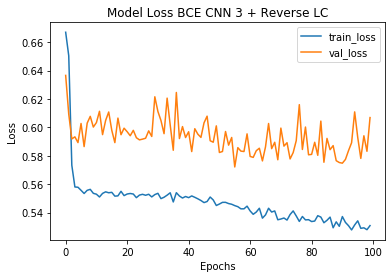

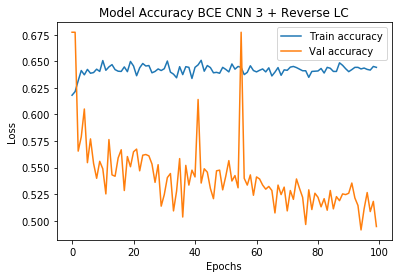

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.985560,0.257547,0.408377,0.456929,0.483608,0.494569
Confirmed,0.388975,0.992079,0.558840,0.456929,0.483608,0.494569


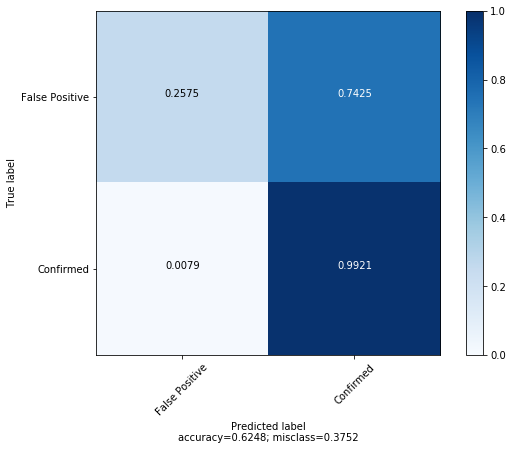

{'Precision raw': array([0.98555957, 0.38897516]), 'Recall raw': array([0.25754717, 0.99207921]), 'F1 raw': array([0.40837696, 0.55883993]), 'F1 weighted': 0.456928912047111, 'F1 macro': 0.4836084482119236, 'F1 micro': 0.49456869009584664, 'Confusion Matrix': array([[273, 787],
       [  4, 501]])}


In [29]:
hist3=model3.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 3 BCE + Reverse LC'))

Train on 4692 samples, validate on 1565 samples
Epoch 1/100
4692/4692 [==============================] - 4s 909us/step - loss: 0.1725 - acc: 0.5100 - val_loss: 0.1652 - val_acc: 0.6780
Epoch 2/100
4692/4692 [==============================] - 3s 743us/step - loss: 0.1515 - acc: 0.6108 - val_loss: 0.1552 - val_acc: 0.5291
Epoch 3/100
4692/4692 [==============================] - 3s 724us/step - loss: 0.1452 - acc: 0.6277 - val_loss: 0.1601 - val_acc: 0.4869
Epoch 4/100
4692/4692 [==============================] - 3s 726us/step - loss: 0.1449 - acc: 0.6275 - val_loss: 0.1536 - val_acc: 0.5291
Epoch 5/100
4692/4692 [==============================] - 3s 732us/step - loss: 0.1446 - acc: 0.6281 - val_loss: 0.1574 - val_acc: 0.4997
Epoch 6/100
4692/4692 [==============================] - 3s 716us/step - loss: 0.1443 - acc: 0.6313 - val_loss: 0.1520 - val_acc: 0.5393
Epoch 7/100
4692/4692 [==============================] - 4s 747us/step - loss: 0.1428 - acc: 0.6317 - val_loss: 0.1623 - val_acc: 

4692/4692 [==============================] - 3s 707us/step - loss: 0.1353 - acc: 0.6513 - val_loss: 0.1587 - val_acc: 0.4728
Epoch 61/100
4692/4692 [==============================] - 3s 720us/step - loss: 0.1346 - acc: 0.6558 - val_loss: 0.1488 - val_acc: 0.5380
Epoch 62/100
4692/4692 [==============================] - 3s 714us/step - loss: 0.1346 - acc: 0.6556 - val_loss: 0.1538 - val_acc: 0.5105
Epoch 63/100
4692/4692 [==============================] - 3s 712us/step - loss: 0.1347 - acc: 0.6535 - val_loss: 0.1561 - val_acc: 0.4882
Epoch 64/100
4692/4692 [==============================] - 3s 707us/step - loss: 0.1348 - acc: 0.6526 - val_loss: 0.1556 - val_acc: 0.5093
Epoch 65/100
4692/4692 [==============================] - 3s 703us/step - loss: 0.1340 - acc: 0.6530 - val_loss: 0.1553 - val_acc: 0.5035
Epoch 66/100
4692/4692 [==============================] - 3s 700us/step - loss: 0.1371 - acc: 0.6460 - val_loss: 0.1560 - val_acc: 0.5073
Epoch 67/100
4692/4692 [=======================

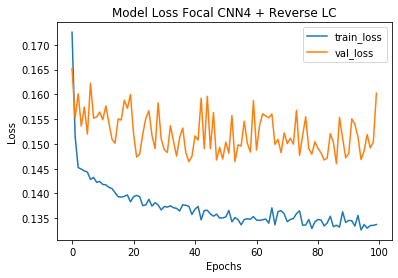

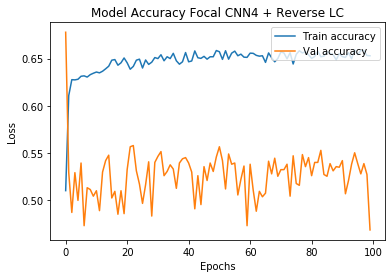

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.991379,0.216981,0.356037,0.417766,0.451686,0.468371
Confirmed,0.377344,0.996040,0.547334,0.417766,0.451686,0.468371


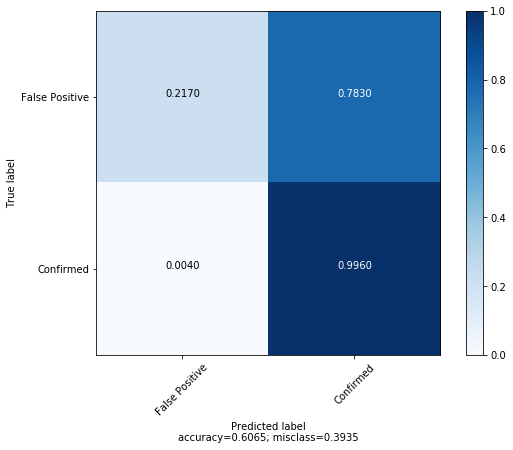

{'Precision raw': array([0.99137931, 0.37734434]), 'Recall raw': array([0.21698113, 0.9960396 ]), 'F1 raw': array([0.35603715, 0.54733406]), 'F1 weighted': 0.41776554663163695, 'F1 macro': 0.4516856052311538, 'F1 micro': 0.468370607028754, 'Confusion Matrix': array([[230, 830],
       [  2, 503]])}


In [30]:
hist4=model4.fit(x_train, y_train_cat, batch_size=64, epochs=100, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist4.history['loss'],label="train_loss")
plt.plot(hist4.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist4.history['acc'],label="Train accuracy" )
plt.plot(hist4.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model4.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 3s 702us/step - loss: 0.5349 - acc: 0.6405 - val_loss: 0.6015 - val_acc: 0.5029
Epoch 2/50
4692/4692 [==============================] - 3s 676us/step - loss: 0.5346 - acc: 0.6409 - val_loss: 0.5849 - val_acc: 0.5118
Epoch 3/50
4692/4692 [==============================] - 3s 683us/step - loss: 0.5278 - acc: 0.6490 - val_loss: 0.5814 - val_acc: 0.5208
Epoch 4/50
4692/4692 [==============================] - 3s 656us/step - loss: 0.5266 - acc: 0.6486 - val_loss: 0.5832 - val_acc: 0.5201
Epoch 5/50
4692/4692 [==============================] - 3s 650us/step - loss: 0.5255 - acc: 0.6498 - val_loss: 0.5795 - val_acc: 0.5246
Epoch 6/50
4692/4692 [==============================] - 3s 656us/step - loss: 0.5244 - acc: 0.6496 - val_loss: 0.5803 - val_acc: 0.5252
Epoch 7/50
4692/4692 [==============================] - 3s 655us/step - loss: 0.5222 - acc: 0.6515 - val_loss: 0.5780 - val_acc: 0.5291


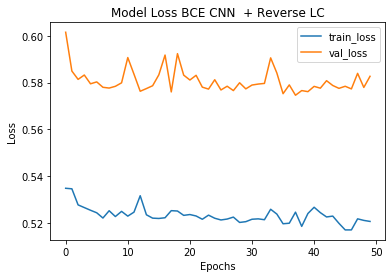

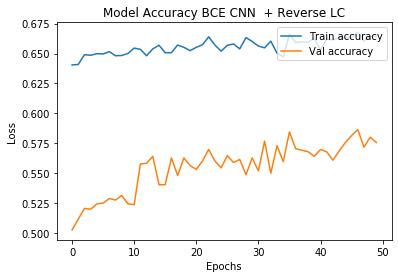

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.757812,0.549057,0.636761,0.589409,0.563388,0.575719
Confirmed,0.400251,0.631683,0.490015,0.589409,0.563388,0.575719


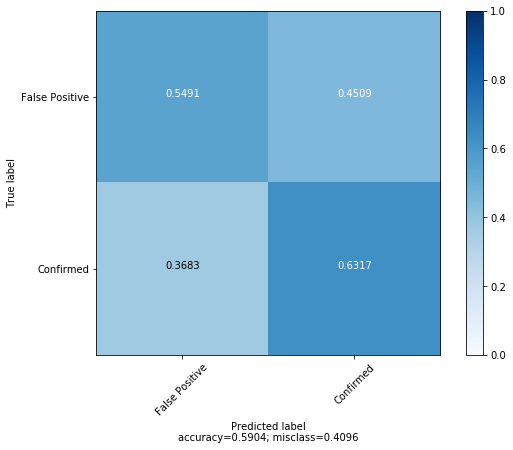

{'Precision raw': array([0.7578125 , 0.40025094]), 'Recall raw': array([0.5490566 , 0.63168317]), 'F1 raw': array([0.63676149, 0.49001536]), 'F1 weighted': 0.5894089038590129, 'F1 macro': 0.5633884244740459, 'F1 micro': 0.5757188498402556, 'Confusion Matrix': array([[582, 478],
       [186, 319]])}


In [31]:
#mini-batches ?
hist3=model3.fit(x_train, y_train, batch_size=256 , epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN BCE + Reverse LC'))

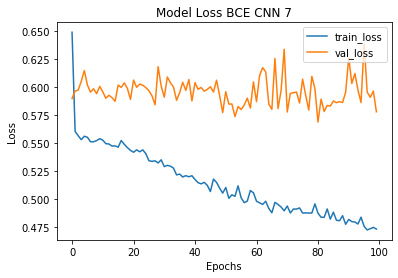

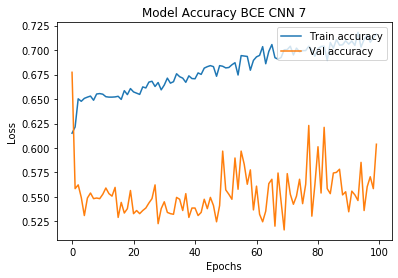

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.806407,0.546226,0.651294,0.615839,0.596357,0.603834
Confirmed,0.432113,0.724752,0.541420,0.615839,0.596357,0.603834


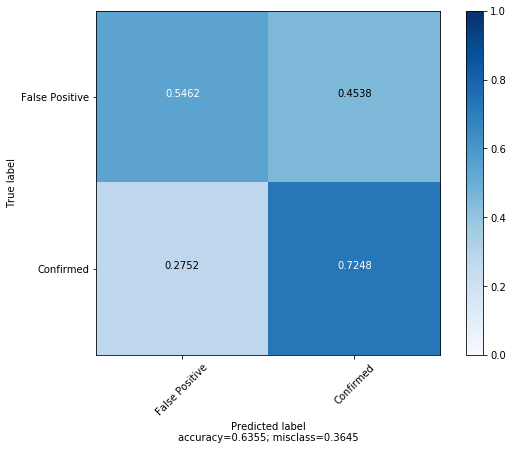

{'Precision raw': array([0.80640669, 0.43211334]), 'Recall raw': array([0.54622642, 0.72475248]), 'F1 raw': array([0.65129359, 0.54142012]), 'F1 weighted': 0.6158392098165263, 'F1 macro': 0.5963568533223289, 'F1 micro': 0.6038338658146964, 'Confusion Matrix': array([[579, 481],
       [139, 366]])}


In [32]:
model7 = Sequential()
model7.add(Conv2D(16, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model7.add(Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Dropout(0.25))
model7.add(GlobalAveragePooling2D())
model7.add(Dense(1, activation='sigmoid'))

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist7=model7.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist7.history['loss'],label="train_loss")
plt.plot(hist7.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist7.history['acc'],label="Train accuracy" )
plt.plot(hist7.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model7.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 7 BCE'))

### Considerando data augmentation

In [33]:
matrices_inv=np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d30.npy')
x_train2=matrices_inv[mask_train]
y_train2=class2int(labels_train)

x_val2=matrices_inv[mask_test]
y_val2=class2int(labels_val)

x_test2=matrices_inv[mask_unlabeled]


x_train2=np.expand_dims(np.asarray(x_train2), axis=-1)
x_val2=np.expand_dims(np.asarray(x_val2), axis=-1)
x_test2=np.expand_dims(np.asarray(x_test2), axis=-1)

print ("Objetos de entrenamiento:",x_train2.shape)
print ("Objetos de validación:",x_val2.shape)
print ("Objetos de testing:",x_test2.shape)

class_weights2 = class_weight.compute_class_weight('balanced', np.unique(y_train2), y_train2)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights2)


Objetos de entrenamiento: (4692, 40, 40, 1)
Objetos de validación: (1565, 40, 40, 1)
Objetos de testing: (1797, 40, 40, 1)
[0.80452675 1.32094595]


In [34]:
class_weights

array([0.80452675, 1.32094595])

In [35]:
x_train_o=np.concatenate([x_train, x_train2])
y_train_o=np.concatenate([y_train, y_train2])

x_val_o=np.concatenate([x_val, x_val2])
y_val_o=np.concatenate([y_val, y_val2])

x_test_o=np.concatenate([x_test, x_test2])

print ("Objetos de entrenamiento:",x_train_o.shape)
print ("Objetos de validación:",x_val_o.shape)
print ("Objetos de testing:",x_test_o.shape)

Objetos de entrenamiento: (9384, 40, 40, 1)
Objetos de validación: (3130, 40, 40, 1)
Objetos de testing: (3594, 40, 40, 1)


Train on 9384 samples, validate on 3130 samples
Epoch 1/50
9384/9384 [==============================] - 135s 14ms/step - loss: 0.5033 - acc: 0.6807 - val_loss: 0.5844 - val_acc: 0.5406
Epoch 2/50
9384/9384 [==============================] - 135s 14ms/step - loss: 0.5000 - acc: 0.6834 - val_loss: 0.5947 - val_acc: 0.5204
Epoch 3/50
9384/9384 [==============================] - 135s 14ms/step - loss: 0.4992 - acc: 0.6830 - val_loss: 0.5920 - val_acc: 0.5332
Epoch 4/50
9384/9384 [==============================] - 135s 14ms/step - loss: 0.4973 - acc: 0.6879 - val_loss: 0.5858 - val_acc: 0.5450
Epoch 5/50
9384/9384 [==============================] - 135s 14ms/step - loss: 0.4951 - acc: 0.6890 - val_loss: 0.5852 - val_acc: 0.5562
Epoch 6/50
9384/9384 [==============================] - 135s 14ms/step - loss: 0.4953 - acc: 0.6890 - val_loss: 0.5822 - val_acc: 0.5527
Epoch 7/50
9384/9384 [==============================] - 136s 14ms/step - loss: 0.4925 - acc: 0.6883 - val_loss: 0.5785 - val_acc: 

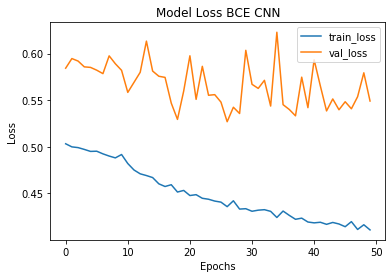

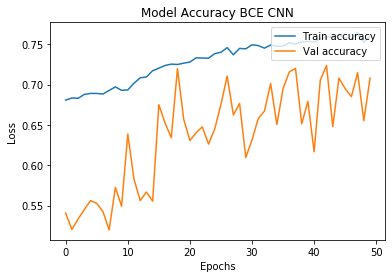

In [36]:
hist=model.fit(x_train_o, y_train_o, batch_size=64, epochs=50, verbose=1, class_weight=class_weights2, validation_data=(x_val_o,y_val_o))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.782833,0.787264,0.785042,0.707527,0.664932,0.707987
Confirmed,0.548096,0.541584,0.544821,0.707527,0.664932,0.707987


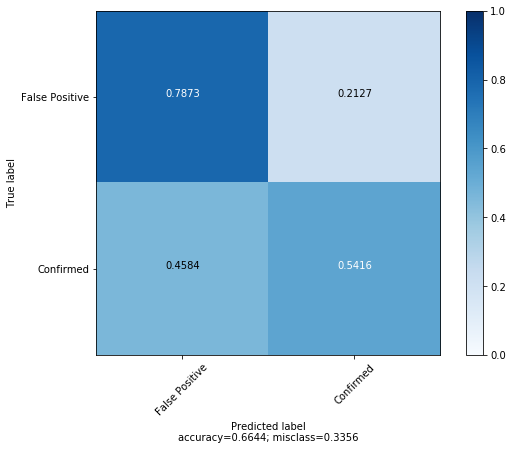

{'Precision raw': array([0.78283302, 0.54809619]), 'Recall raw': array([0.78726415, 0.54158416]), 'F1 raw': array([0.78504233, 0.54482072]), 'F1 weighted': 0.7075267317267316, 'F1 macro': 0.6649315250756147, 'F1 micro': 0.7079872204472843, 'Confusion Matrix': array([[1669,  451],
       [ 463,  547]])}


In [37]:
predichos=model.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

Train on 9384 samples, validate on 3130 samples
Epoch 1/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.5039 - acc: 0.6813 - val_loss: 0.5892 - val_acc: 0.5441
Epoch 2/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.5043 - acc: 0.6806 - val_loss: 0.5817 - val_acc: 0.5460
Epoch 3/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.5071 - acc: 0.6768 - val_loss: 0.5906 - val_acc: 0.5422
Epoch 4/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.5022 - acc: 0.6818 - val_loss: 0.5802 - val_acc: 0.5546
Epoch 5/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.4985 - acc: 0.6844 - val_loss: 0.5998 - val_acc: 0.5342
Epoch 6/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.5047 - acc: 0.6831 - val_loss: 0.5833 - val_acc: 0.5431
Epoch 7/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.4983 - acc: 0.6849 - val_loss: 0.5758 - val_acc: 0.5655
Epoch 8

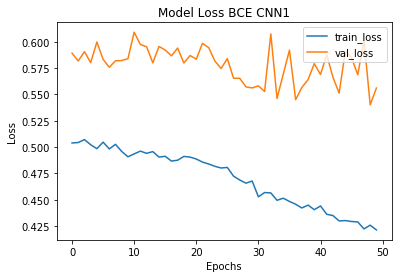

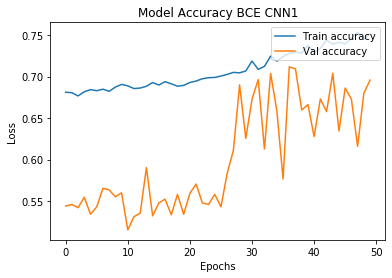

In [38]:
hist1=model1.fit(x_train_o, y_train_o, batch_size=64, epochs=50, verbose=1, class_weight=class_weights2, validation_data=(x_val_o,y_val_o))
plt.plot(hist1.history['loss'],label="train_loss")
plt.plot(hist1.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist1.history['acc'],label="Train accuracy" )
plt.plot(hist1.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.791708,0.747642,0.769044,0.699887,0.661884,0.695847
Confirmed,0.525709,0.587129,0.554724,0.699887,0.661884,0.695847


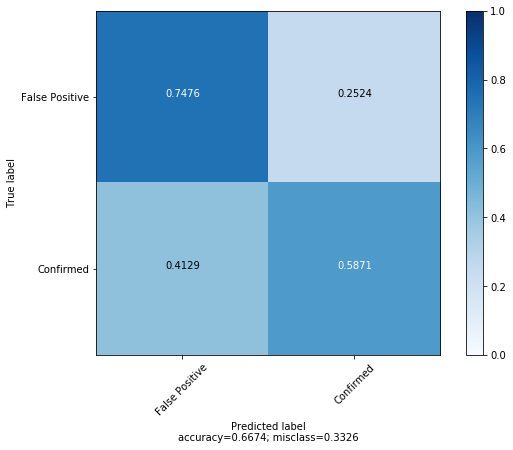

{'Precision raw': array([0.79170829, 0.52570922]), 'Recall raw': array([0.74764151, 0.58712871]), 'F1 raw': array([0.76904415, 0.55472404]), 'F1 weighted': 0.6998865452452575, 'F1 macro': 0.6618840972417959, 'F1 micro': 0.6958466453674121, 'Confusion Matrix': array([[1585,  535],
       [ 417,  593]])}


In [39]:
predichos=model1.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 + Reverse LC'))

In [40]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model2.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss=focal_loss(2,weights=class_weights2),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 40, 40, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 20, 256)       295168    
_________________________________________________________________
global_average_pooling2d_9 ( (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
__________

In [41]:
y_train_cat_o=to_categorical(y_train_o, 2)
y_train_cat_o[:3]
y_val_cat_o=to_categorical(y_val_o, 2)
y_val_cat_o[:3]

array([[0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Train on 9384 samples, validate on 3130 samples
Epoch 1/50
9384/9384 [==============================] - 15s 2ms/step - loss: 0.1517 - acc: 0.6154 - val_loss: 0.1531 - val_acc: 0.5470
Epoch 2/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.1438 - acc: 0.6370 - val_loss: 0.1576 - val_acc: 0.4942
Epoch 3/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.1437 - acc: 0.6330 - val_loss: 0.1546 - val_acc: 0.5466
Epoch 4/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.1431 - acc: 0.6360 - val_loss: 0.1533 - val_acc: 0.5319
Epoch 5/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.1430 - acc: 0.6371 - val_loss: 0.1611 - val_acc: 0.5042
Epoch 6/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.1420 - acc: 0.6340 - val_loss: 0.1545 - val_acc: 0.5367
Epoch 7/50
9384/9384 [==============================] - 14s 1ms/step - loss: 0.1415 - acc: 0.6408 - val_loss: 0.1530 - val_acc: 0.5316
Epoch 8

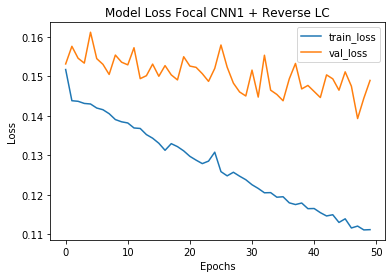

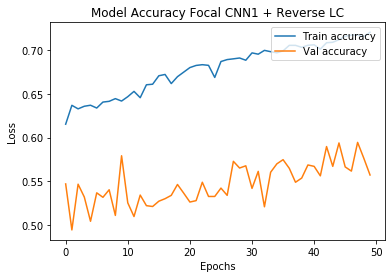

In [42]:
hist2=model2.fit(x_train_o, y_train_cat_o, batch_size=64, epochs=50, verbose=1, class_weight=class_weights2, validation_data=(x_val_o,y_val_cat_o))
plt.plot(hist2.history['loss'],label="train_loss")
plt.plot(hist2.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist2.history['acc'],label="Train accuracy" )
plt.plot(hist2.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.957606,0.362264,0.525667,0.544742,0.555224,0.557188
Confirmed,0.419244,0.966337,0.584781,0.544742,0.555224,0.557188


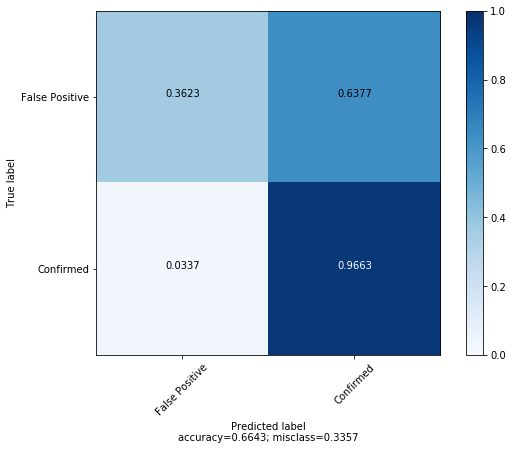

{'Precision raw': array([0.95760599, 0.41924399]), 'Recall raw': array([0.36226415, 0.96633663]), 'F1 raw': array([0.52566735, 0.58478131]), 'F1 weighted': 0.5447424612227872, 'F1 macro': 0.5552243286503618, 'F1 micro': 0.5571884984025559, 'Confusion Matrix': array([[ 768, 1352],
       [  34,  976]])}


In [43]:
predichos=model2.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

In [44]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.25))
model3.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.15))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.1))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))

model4.compile(loss=focal_loss(2,weights=class_weights2),optimizer='adam',metrics=['acc'])

Train on 9384 samples, validate on 3130 samples
Epoch 1/100
9384/9384 [==============================] - 8s 898us/step - loss: 0.6586 - acc: 0.6213 - val_loss: 0.6156 - val_acc: 0.6773
Epoch 2/100
9384/9384 [==============================] - 7s 754us/step - loss: 0.5706 - acc: 0.6379 - val_loss: 0.6012 - val_acc: 0.5591
Epoch 3/100
9384/9384 [==============================] - 7s 751us/step - loss: 0.5561 - acc: 0.6435 - val_loss: 0.6056 - val_acc: 0.5498
Epoch 4/100
9384/9384 [==============================] - 7s 748us/step - loss: 0.5559 - acc: 0.6471 - val_loss: 0.6010 - val_acc: 0.5537
Epoch 5/100
9384/9384 [==============================] - 7s 783us/step - loss: 0.5541 - acc: 0.6406 - val_loss: 0.6158 - val_acc: 0.5278
Epoch 6/100
9384/9384 [==============================] - 7s 729us/step - loss: 0.5550 - acc: 0.6443 - val_loss: 0.6052 - val_acc: 0.5505
Epoch 7/100
9384/9384 [==============================] - 7s 730us/step - loss: 0.5534 - acc: 0.6396 - val_loss: 0.5942 - val_acc: 

9384/9384 [==============================] - 7s 719us/step - loss: 0.5178 - acc: 0.6646 - val_loss: 0.5868 - val_acc: 0.5764
Epoch 61/100
9384/9384 [==============================] - 7s 718us/step - loss: 0.5170 - acc: 0.6672 - val_loss: 0.5682 - val_acc: 0.6029
Epoch 62/100
9384/9384 [==============================] - 7s 723us/step - loss: 0.5134 - acc: 0.6735 - val_loss: 0.5834 - val_acc: 0.5901
Epoch 63/100
9384/9384 [==============================] - 7s 744us/step - loss: 0.5145 - acc: 0.6732 - val_loss: 0.5776 - val_acc: 0.5920
Epoch 64/100
9384/9384 [==============================] - 7s 743us/step - loss: 0.5119 - acc: 0.6797 - val_loss: 0.5709 - val_acc: 0.6153
Epoch 65/100
9384/9384 [==============================] - 7s 738us/step - loss: 0.5170 - acc: 0.6634 - val_loss: 0.5661 - val_acc: 0.6307
Epoch 66/100
9384/9384 [==============================] - 7s 715us/step - loss: 0.5128 - acc: 0.6758 - val_loss: 0.5782 - val_acc: 0.6157
Epoch 67/100
9384/9384 [=======================

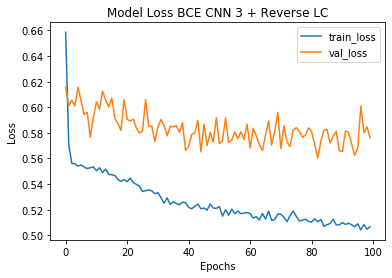

In [45]:
hist3=model3.fit(x_train_o, y_train_o, batch_size=64, epochs=100, verbose=1, class_weight=class_weights2, validation_data=(x_val_o,y_val_o))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

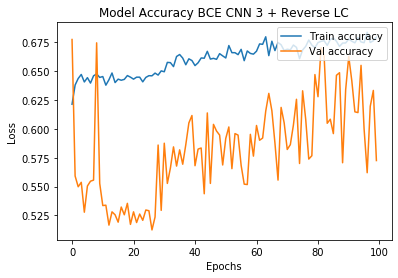

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.860701,0.440094,0.582397,0.575871,0.572285,0.572524
Confirmed,0.419844,0.850495,0.562173,0.575871,0.572285,0.572524


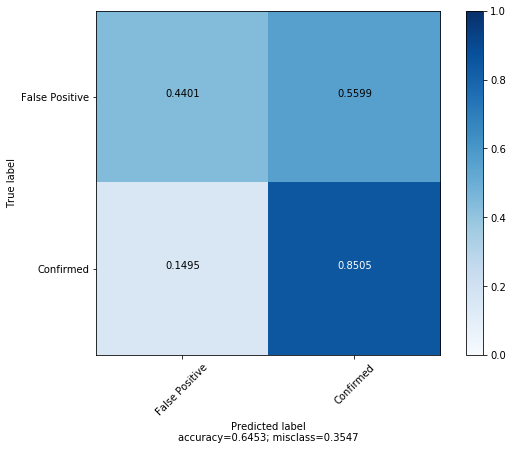

{'Precision raw': array([0.86070111, 0.4198436 ]), 'Recall raw': array([0.44009434, 0.85049505]), 'F1 raw': array([0.582397  , 0.56217277]), 'F1 weighted': 0.5758709746191296, 'F1 macro': 0.5722848893072141, 'F1 micro': 0.5725239616613419, 'Confusion Matrix': array([[ 933, 1187],
       [ 151,  859]])}


In [46]:
plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 50 epochs CNN 3 BCE + Reverse LC'))


Train on 9384 samples, validate on 3130 samples
Epoch 1/100
9384/9384 [==============================] - 8s 873us/step - loss: 0.1665 - acc: 0.5663 - val_loss: 0.1553 - val_acc: 0.5383
Epoch 2/100
9384/9384 [==============================] - 7s 764us/step - loss: 0.1464 - acc: 0.6324 - val_loss: 0.1601 - val_acc: 0.4923
Epoch 3/100
9384/9384 [==============================] - 7s 757us/step - loss: 0.1442 - acc: 0.6308 - val_loss: 0.1523 - val_acc: 0.5307
Epoch 4/100
9384/9384 [==============================] - 7s 728us/step - loss: 0.1437 - acc: 0.6322 - val_loss: 0.1528 - val_acc: 0.5262
Epoch 5/100
9384/9384 [==============================] - 7s 739us/step - loss: 0.1434 - acc: 0.6293 - val_loss: 0.1574 - val_acc: 0.4984
Epoch 6/100
9384/9384 [==============================] - 7s 712us/step - loss: 0.1424 - acc: 0.6348 - val_loss: 0.1615 - val_acc: 0.4773
Epoch 7/100
9384/9384 [==============================] - 7s 715us/step - loss: 0.1411 - acc: 0.6371 - val_loss: 0.1502 - val_acc: 

9384/9384 [==============================] - 7s 735us/step - loss: 0.1328 - acc: 0.6569 - val_loss: 0.1482 - val_acc: 0.5444
Epoch 61/100
9384/9384 [==============================] - 7s 741us/step - loss: 0.1331 - acc: 0.6558 - val_loss: 0.1464 - val_acc: 0.5393
Epoch 62/100
9384/9384 [==============================] - 7s 726us/step - loss: 0.1327 - acc: 0.6579 - val_loss: 0.1461 - val_acc: 0.5390
Epoch 63/100
9384/9384 [==============================] - 7s 739us/step - loss: 0.1326 - acc: 0.6552 - val_loss: 0.1469 - val_acc: 0.5412
Epoch 64/100
9384/9384 [==============================] - 7s 729us/step - loss: 0.1329 - acc: 0.6586 - val_loss: 0.1484 - val_acc: 0.5335
Epoch 65/100
9384/9384 [==============================] - 7s 723us/step - loss: 0.1321 - acc: 0.6564 - val_loss: 0.1443 - val_acc: 0.5396
Epoch 66/100
9384/9384 [==============================] - 7s 718us/step - loss: 0.1331 - acc: 0.6559 - val_loss: 0.1478 - val_acc: 0.5403
Epoch 67/100
9384/9384 [=======================

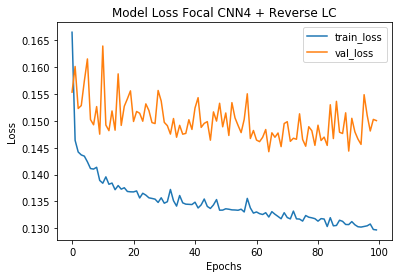

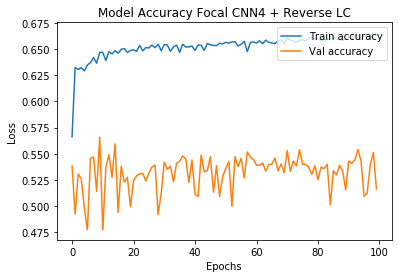

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.980983,0.291981,0.450018,0.488355,0.509421,0.516613
Confirmed,0.399360,0.988119,0.568823,0.488355,0.509421,0.516613


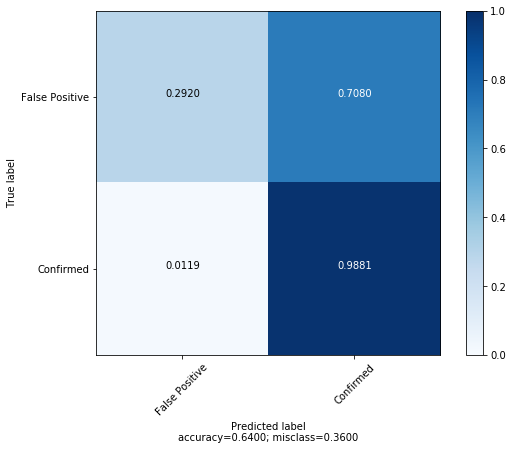

{'Precision raw': array([0.98098257, 0.39935974]), 'Recall raw': array([0.29198113, 0.98811881]), 'F1 raw': array([0.45001818, 0.56882303]), 'F1 weighted': 0.4883545649237768, 'F1 macro': 0.509420600856146, 'F1 micro': 0.5166134185303515, 'Confusion Matrix': array([[ 619, 1501],
       [  12,  998]])}


In [47]:
hist4=model4.fit(x_train_o, y_train_cat_o, batch_size=64, epochs=100, verbose=1, class_weight=class_weights2, validation_data=(x_val_o,y_val_cat_o))
plt.plot(hist4.history['loss'],label="train_loss")
plt.plot(hist4.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist4.history['acc'],label="Train accuracy" )
plt.plot(hist4.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model4.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

Train on 9384 samples, validate on 3130 samples
Epoch 1/50
9384/9384 [==============================] - 7s 698us/step - loss: 0.5027 - acc: 0.6839 - val_loss: 0.5711 - val_acc: 0.6035
Epoch 2/50
9384/9384 [==============================] - 6s 660us/step - loss: 0.5002 - acc: 0.6858 - val_loss: 0.5680 - val_acc: 0.6300
Epoch 3/50
9384/9384 [==============================] - 6s 673us/step - loss: 0.5014 - acc: 0.6862 - val_loss: 0.5695 - val_acc: 0.6377
Epoch 4/50
9384/9384 [==============================] - 6s 664us/step - loss: 0.4990 - acc: 0.6880 - val_loss: 0.5708 - val_acc: 0.6498
Epoch 5/50
9384/9384 [==============================] - 6s 667us/step - loss: 0.4986 - acc: 0.6853 - val_loss: 0.5745 - val_acc: 0.6524
Epoch 6/50
9384/9384 [==============================] - 6s 672us/step - loss: 0.5030 - acc: 0.6827 - val_loss: 0.5777 - val_acc: 0.6361
Epoch 7/50
9384/9384 [==============================] - 6s 658us/step - loss: 0.4978 - acc: 0.6887 - val_loss: 0.5652 - val_acc: 0.6569


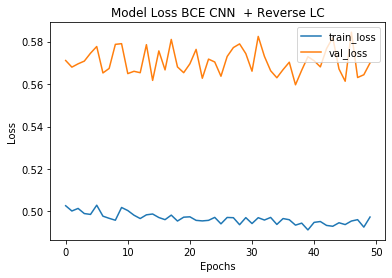

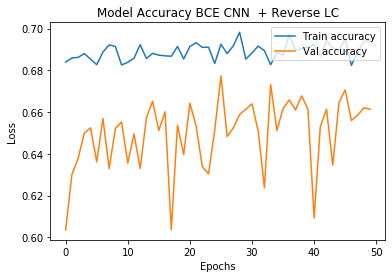

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.770408,0.712264,0.740196,0.667129,0.626979,0.661342
Confirmed,0.478632,0.554455,0.513761,0.667129,0.626979,0.661342


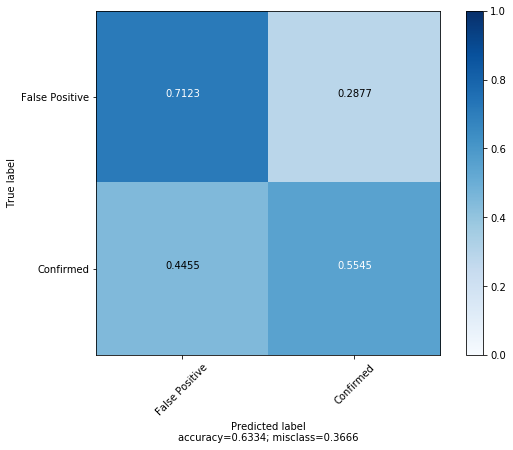

{'Precision raw': array([0.77040816, 0.47863248]), 'Recall raw': array([0.71226415, 0.55445545]), 'F1 raw': array([0.74019608, 0.51376147]), 'F1 weighted': 0.6671293191192706, 'F1 macro': 0.6269787731606404, 'F1 micro': 0.6613418530351438, 'Confusion Matrix': array([[1510,  610],
       [ 450,  560]])}


In [48]:
hist3=model3.fit(x_train_o, y_train_o, batch_size=256 , epochs=50, verbose=1, class_weight=class_weights2, validation_data=(x_val_o,y_val_o))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 50 epochs CNN BCE + Reverse LC'))

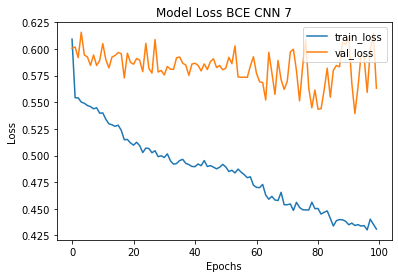

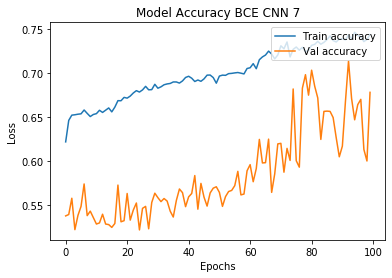

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.788791,0.716981,0.751174,0.684632,0.648068,0.678275
Confirmed,0.501247,0.597030,0.544962,0.684632,0.648068,0.678275


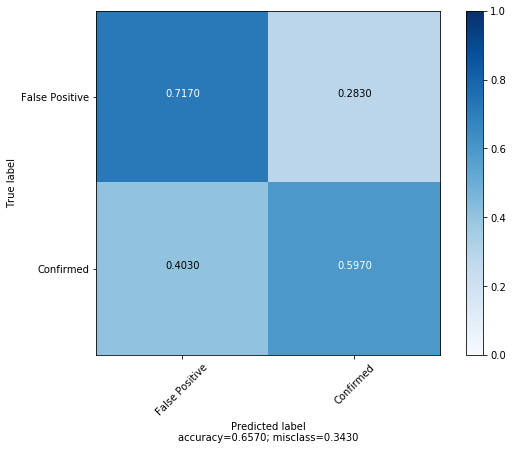

{'Precision raw': array([0.78879087, 0.50124688]), 'Recall raw': array([0.71698113, 0.5970297 ]), 'F1 raw': array([0.75117371, 0.54496159]), 'F1 weighted': 0.6846324183443456, 'F1 macro': 0.6480676497605908, 'F1 micro': 0.6782747603833866, 'Confusion Matrix': array([[1520,  600],
       [ 407,  603]])}


In [49]:
model7 = Sequential()
model7.add(Conv2D(16, (3, 3), input_shape=(40,40,1), strides=(1, 1),activation="relu", padding="same"))
model7.add(Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Dropout(0.25))
model7.add(GlobalAveragePooling2D())
model7.add(Dense(1, activation='sigmoid'))

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist7=model7.fit(x_train_o, y_train_o, batch_size=128, epochs=100, verbose=0, class_weight=class_weights2, validation_data=(x_val_o,y_val_o))
plt.plot(hist7.history['loss'],label="train_loss")
plt.plot(hist7.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist7.history['acc'],label="Train accuracy" )
plt.plot(hist7.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model7.predict_classes(x_val_o)
print (calculate_metrics(y_val_o,predichos,'[VAL] Confusion Matrix 100 epochs CNN 7 BCE'))